In [30]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *

from annotation_utilities import *

import matplotlib.pyplot as plt
%matplotlib inline

import time

Setting environment for Gordon
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
username = 'yuncong'
# stack = 'MD589'
stack = 'MD594'

In [33]:
label_polygons = load_label_polygons_if_exists(stack, username, downsample=1, force=True, annotation_rootdir=annotation_midbrainIncluded_v2_rootdir)

Loaded annotation /oasis/projects/nsf/csd395/yuncong/CSHL_labelings_v2/MD594/MD594_sagittal_downsample1_yuncong_08212016024302.pkl.
Label GrC on Section 96 is not recognized.
Label VCA on Section 96 is not recognized.
Label GrC on Section 98 is not recognized.
Label VCA on Section 98 is not recognized.
Label VCA on Section 100 is not recognized.
Label GrC on Section 100 is not recognized.
Label VCA on Section 102 is not recognized.
Label VCA on Section 104 is not recognized.
Label VCA on Section 106 is not recognized.
Label VCP on Section 106 is not recognized.
Label DC on Section 106 is not recognized.
Label DC on Section 108 is not recognized.
Label VCA on Section 108 is not recognized.
Label VCP on Section 108 is not recognized.
Label VCP on Section 110 is not recognized.
Label VCA on Section 110 is not recognized.
Label VCAGr on Section 110 is not recognized.
Label DC on Section 110 is not recognized.
Label VCAGr on Section 112 is not recognized.
Label VCP on Section 112 is not rec

In [22]:
# landmark_range_limits = get_landmark_range_limits(label_polygons=label_polygons)

In [34]:
label_polygons_sideAssigned = assign_sideness(label_polygons)

Structure DRV has label on only one section.
Left and right labels for DRI overlap.
[Resolved] using inferred maxL/minR.
Left and right labels for scp overlap.
[Resolved] using inferred maxL/minR.
Structure tz has label on only one section.
Structure MPBE has label on only one section.
Left and right labels for Bar overlap.
[Resolved] using inferred maxL/minR.
Structure PrC has label on only one section.
Left and right labels for RPF overlap.
[Resolved] using inferred maxL/minR.
Left and right labels for IPC overlap.
[Resolved] using inferred maxL/minR.
Left and right labels for IPA overlap.
[Resolved] using inferred maxL/minR.
Left and right labels for IPR overlap.
[Resolved] using inferred maxL/minR.
Left and right labels for 3N overlap.
[Resolved] using inferred maxL/minR.
Structure SCO has label on only one section.
Left and right labels for DTg overlap.
[Resolved] using inferred maxL/minR.
Left and right labels for EVe overlap.
[Resolved] using inferred maxL/minR.
Left and right l

In [35]:
sided_label_polygons_path = os.path.join(annotation_midbrainIncluded_v2_rootdir, 
                                   '%(stack)s_%(username)s_annotation_polygons_sided.h5' % {'stack': stack, 'username': username})
label_polygons_sideAssigned.to_hdf(sided_label_polygons_path, 'label_polygons')

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/pandas/core/generic.py:939: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['10N_L', '10N_R', '12N', '3N_L', '3N_R', '4N_L', '4N_R', '5N_L', '5N_R', '6N_L', '6N_R', '7N2_L', '7N2_R', '7N_L', '7N_R', '7n_L', '7n_R', '8n_L', '8n_R', 'AP', 'APT_L', 'APT_R', 'Amb_L', 'Amb_R', 'Bar_L', 'Bar_R', 'CGA_R', 'CereNuc_L', 'CereNuc_R', 'CnF_L', 'CnF_R', 'Cu_L', 'Cu_R', 'DCDp_L', 'DCDp_R', 'DCFu_L', 'DCFu_R', 'DCMo_L', 'DCMo_R', 'DC_L', 'DC_R', 'DLL_L', 'DLL_R', 'DPO_L', 'DPO_R', 'DRD_L', 'DRD_R', 'DRI_L', 'DRI_R', 'DRV_L', 'DTgC_L', 'DTgC_R', 'DTgP_L', 'DTgP_R', 'DTg_L', 'DTg_R', 'Dk_L', 'Dk_R', 'ECu_L', 'ECu_R', 'EVe_L', 'EVe_R', 'EW_L', 'EW_R', 'GrC_L', 'GrC_R', 'Gr_L', 'Gr_R', 'IC_L', 'IC_R', 'IF_L', 'IF_R', 'IO_L', 'IO_R', 'IPA_L', 'IPA_R', 'IPC_L', 'IPC_R', 'IPR_L', 'IPR_R', 'In

In [36]:
downsample_factor = 16
xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [37]:
name_list = ['background'] + list(label_polygons_sideAssigned.keys())
print len(name_list)

218


In [38]:
dm = DataManager(stack=stack)

img_height_downsampled = dm.image_height/downsample_factor
img_width_downsampled = dm.image_width/downsample_factor

volume = np.zeros((img_height_downsampled, img_width_downsampled, 
                   int(section_number_lookup[stack]*z_xy_ratio_downsampled)), np.uint8)

print volume.shape

(724, 1028, 1173)


In [39]:
for name in label_polygons_sideAssigned.keys():
    print name
    index = name_list.index(name)
    
    contours_grouped_by_z = {}
    for sec, xys in label_polygons_sideAssigned[name].dropna().to_dict().iteritems():
        z0, z1 = DataManager.convert_section_to_z(stack=stack, sec=sec, downsample=1, z_begin=0)
        z = (z0 + z1) / 2
        contours_grouped_by_z[z / downsample_factor] = xys / downsample_factor
        
    interpolated_contours = get_interpolated_contours(contours_grouped_by_z)
    
    interpolated_interior_points = {z: points_inside_contour(contour_pts.astype(np.int)) 
                                    for z, contour_pts in interpolated_contours.iteritems()}
    
#     occupied_names_covered = np.zeros((len(name_list), ), np.int)
    
    for z, xys in interpolated_interior_points.iteritems():
#         occupied_names_covered += np.bincount(volume[xys[:,1], xys[:,0], z], minlength=len(name_list))
        volume[xys[:,1], xys[:,0], z] = index
    
#     occupied_names_percentage = occupied_names_covered / float(occupied_names_covered.sum())
    
#     occupied_names_dict = {name_list[i]: percent for i, percent in enumerate(occupied_names_percentage) if i != 0 and i != index and percent > 0}
#     if len(occupied_names_dict) > 0:
#         print 'percent volume overlapping/replacing existing structures'
#         print occupied_names_dict
    

10N_L
10N_R
12N
3N_L
3N_R
4N_L
4N_R
5N_L
5N_R
6N_L
6N_R
7N2_L
7N2_R
7N_L
7N_R
7n_L
7n_R
8n_L
8n_R
AP
APT_L
APT_R
Amb_L
Amb_R
Bar_L
Bar_R
CGA_R
CereNuc_L
CereNuc_R
CnF_L
CnF_R
Cu_L
Cu_R
DCDp_L
DCDp_R
DCFu_L
DCFu_R
DCMo_L
DCMo_R
DC_L
DC_R
DLL_L
DLL_R
DPO_L
DPO_R
DRD_L
DRD_R
DRI_L
DRI_R
DRV_L
DTgC_L
DTgC_R
DTgP_L
DTgP_R
DTg_L
DTg_R
Dk_L
Dk_R
ECu_L
ECu_R
EVe_L
EVe_R
EW_L
EW_R
GrC_L
GrC_R
Gr_L
Gr_R
IC_L
IC_R
IF_L
IF_R
IO_L
IO_R
IPA_L
IPA_R
IPC_L
IPC_R
IPR_L
IPR_R
InC_L
InC_R
LC_L
LC_R
LDTg_L
LDTg_R
LPBD_L
LPBD_R
LPBE_L
LPBE_R
LPB_L
LPB_R
LPGi_L
LPGi_R
LRt_L
LRt_R
LSO_L
LSO_R
LVPO_L
LVPO_R
LVe_L
LVe_R
Li_L
Li_R
MPBE_L
MPB_L
MPB_R
MVPO_L
MVPO_R
MVeMC_L
MVeMC_R
Me5_L
Me5_R
MiTg_L
MiTg_R
MnR_L
MnR_R
Op_L
Op_R
PBG_L
PBG_R
PCom_R
PDR_R
PDTg_L
PDTg_R
PPT_L
PTg_L
PTg_R
Pn_L
Pn_R
Pr5DM_L
Pr5DM_R
Pr5VL_L
Pr5VL_R
Pr5_L
Pr5_R
PrC_R
PrVd_L
PrVd_R
PrVv_L
PrVv_R
RMC_L
RMC_R
RPF_L
RPF_R
RR_L
RR_R
R_L
R_R
RtTg
SCO_L
SC_L
SC_R
SGe_L
SGe_R
SNCD_L
SNCD_R
SNC_L
SNC_R
SNR_L
SNR_R
SPO_L
SPO_R
Sol_L
Sol_R
Sp5C_L
S

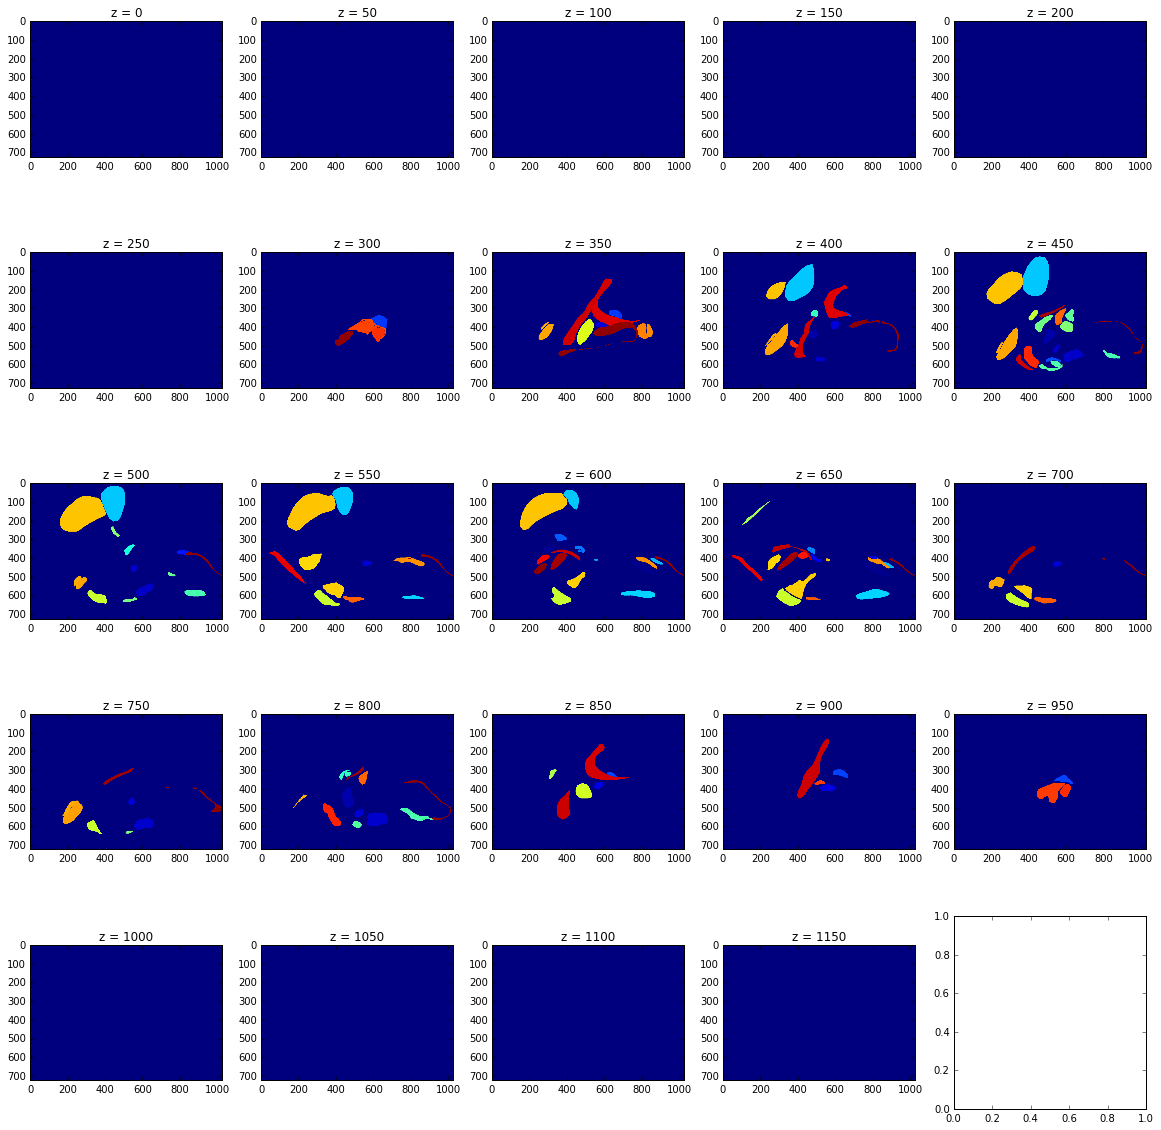

In [40]:
fig, axes = plt.subplots(5, 5, figsize=(20,20) , squeeze=True);
axes = axes.flatten()
for i, z in enumerate(range(0, volume.shape[2], 50)):
    axes[i].imshow(volume[..., z], vmin=0, vmax=len(name_list));
    axes[i].set_title('z = %d' % z);
plt.show();

In [41]:
xmin, xmax, ymin, ymax, zmin, zmax = bbox_3d(volume)

print 'volume bbox dimension:', xmin, xmax, ymin, ymax, zmin, zmax

reduced_xdim = xmax+1-xmin
reduced_ydim = ymax+1-ymin
reduced_zdim = zmax+1-zmin
print 'reduced bbox dimension:', reduced_xdim, reduced_ydim, reduced_zdim

volume bbox dimension: 19 1026 18 666 262 985
reduced bbox dimension: 1008 649 724


In [42]:
reduced_volume = volume[ymin:ymax+1, xmin:xmax+1, zmin:zmax+1]

In [43]:
# output

bp.pack_ndarray_file(reduced_volume, os.path.join(volume_dir, '%(stack)s/%(stack)s_annotationVolume.bp' % {'stack': stack}))

In [44]:
with open(os.path.join(volume_dir, '%(stack)s/%(stack)s_annotationVolume_limits.txt' % {'stack': stack}), 'w') as f:
        f.write((' '.join(['%d']*6)+'\n') % (xmin, xmax, ymin, ymax, zmin, zmax))
        
with open(os.path.join(volume_dir, '%(stack)s/%(stack)s_annotationVolume_resolution.txt' % {'stack': stack}), 'w') as f:
        f.write((' '.join(['%f']*3)+'\n') % (downsample_factor, xy_pixel_distance_downsampled, z_xy_ratio_downsampled))

In [46]:
with open(os.path.join(volume_dir, '%(stack)s/%(stack)s_annotationVolume_labelIndices.txt' % {'stack': stack}), 'w') as f:
#     f.write('BackG 0\n')
    for index, name_s in enumerate(name_list):
        f.write(name_s + ' ' + str(index) + '\n')

In [45]:
with open(os.path.join(volume_dir, '%(stack)s/%(stack)s_annotationVolume_landmarkBboxes.txt' % {'stack': stack}), 'w') as f:
    for index, name in enumerate(name_list):
        if name == 'background': continue
        
        try:
            bbox = bbox_3d(reduced_volume == index)
        except Exception as e:
            sys.stderr.write('Error computing bounding box for structure %s\n' % name)
            bbox = (0,0,0,0,0,0)
                        
        f.write(name + ' ' + ' '.join(map(str, bbox)) + '\n')

Error computing bounding box for structure DCFu_R
Error computing bounding box for structure PPT_L
